# Experiments with Fitzpatrick17K

To avoid further confusion by libraries' dependency, we resized the image's height from 450 and width from 600 to 300 and 300 pixels, respectively.

In [21]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

import imageprocessing
from imageprocessing import ImageResize, MaskedImage
from kerasmodels import CreateGenerator, CNNModel
import attacks
from skincolors import IndividualTypologyAngle
from distance import DistanceMeasure

## Load data

In [22]:
db = "FITZ"
root = f"../../dataset/IEEE/{db}/"

train_df = pd.read_csv(f"{root}exp/train_df.csv")
valid_df = pd.read_csv(f"{root}exp/valid_df.csv")
test_df = pd.read_csv(f"{root}exp/test_df.csv")

In [23]:
train_df["labels"] = train_df["labels"].astype(str)
valid_df["labels"] = valid_df["labels"].astype(str)
test_df["labels"] = test_df["labels"].astype(str)

## Create image generator

In [24]:
sample_image_path = train_df["filepath"].iloc[0]
img_size = imageprocessing.get_image_size(sample_image_path)
print("H*W: ", img_size)

H*W:  (300, 300)


In [25]:
batch_size=8
img_size = img_size
cg = CreateGenerator(img_size, batch_size)
train_gen = cg.train_generator(train_df)
valid_gen = cg.valid_generator(valid_df)
test_gen = cg.valid_generator(test_df)

Found 2000 validated image filenames belonging to 2 classes.
Found 899 validated image filenames belonging to 2 classes.
Found 900 validated image filenames belonging to 2 classes.


## Training

In [26]:
import torch # Due to keras version
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=[300, 300, 3]))
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
        
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
        
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
        
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=32, activation="relu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=1, activation="sigmoid", kernel_initializer="glorot_uniform", name="classifier"))
        
model.compile(Adam(learning_rate= 0.00001), loss= "binary_crossentropy", metrics= ["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 300, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │     5,607,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,886,273 (22.45 MB)

 Trainable params: 5,885,761 (22.45 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20


/home/kuniko/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.5391 - loss: 0.8553 - val_accuracy: 0.5206 - val_loss: 0.7641
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.5826 - loss: 0.7292 - val_accuracy: 0.5884 - val_loss: 0.7302
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.5956 - loss: 0.6704 - val_accuracy: 0.5806 - val_loss: 0.7352
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.6312 - loss: 0.6634 - val_accuracy: 0.6051 - val_loss: 0.7600
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.6240 - loss: 0.6440 - val_accuracy: 0.6118 - val_loss: 0.7302
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.6741 - loss: 0.6033 - val_accuracy: 0.6051 - val_loss: 0.7400
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.6407 - loss: 0.6246 - val_accuracy: 0.6162 - val_loss: 0.7307
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.6928 - loss: 0.5803 - val_accurac

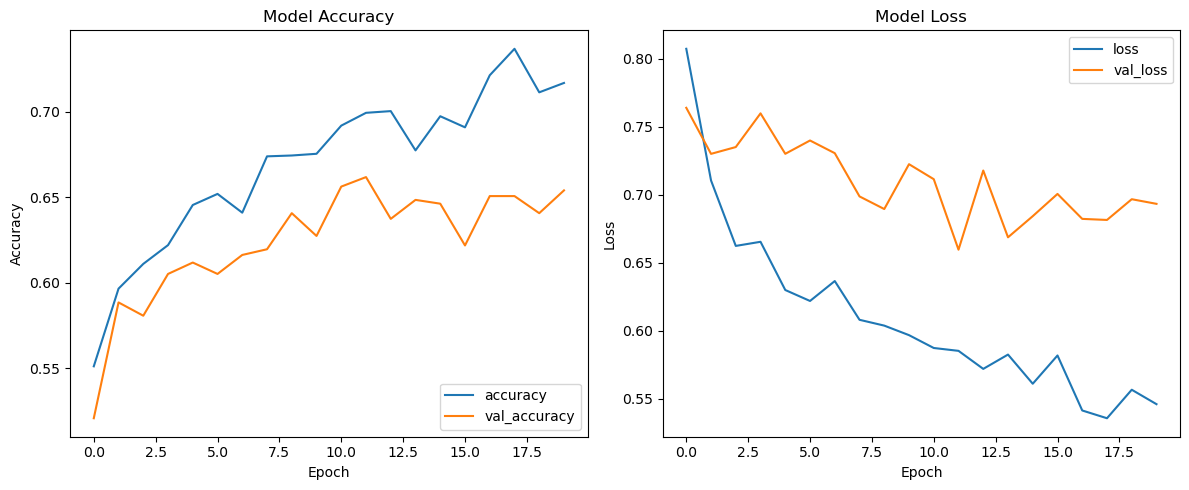

In [27]:
epochs = 20
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[callback])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax[0].plot(history.history["accuracy"], label="accuracy")
ax[0].plot(history.history["val_accuracy"], label="val_accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="lower right")
ax[0].set_title("Model Accuracy")

# Loss
ax[1].plot(history.history["loss"], label="loss")
ax[1].plot(history.history["val_loss"], label="val_loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper right")
ax[1].set_title("Model Loss")

plt.tight_layout()
plt.show()

## Evaluation

In [28]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss", test_loss)
print("Test Accuracy", test_acc)
pred = model.predict(test_gen, verbose=0)
pred_class = ["1" if p[0] >= 0.5 else "0" for p in pred]

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6498 - loss: 0.6512
Test Loss 0.6793128848075867
Test Accuracy 0.6422222256660461


In [29]:
test_df["pred"] = pred_class
print(classification_report(test_df["labels"], test_df["pred"]))

              precision    recall  f1-score   support

           0       0.63      0.68      0.65       447
           1       0.66      0.60      0.63       453

    accuracy                           0.64       900
   macro avg       0.64      0.64      0.64       900
weighted avg       0.64      0.64      0.64       900



# Adversarial attacks

## Random Noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label: 0
Prediction: [[0.83796024]]
Prediction class: ['1']
Adversarial Prediction: [[0.0005763]]
Adversarial Predicted Class: ['0']


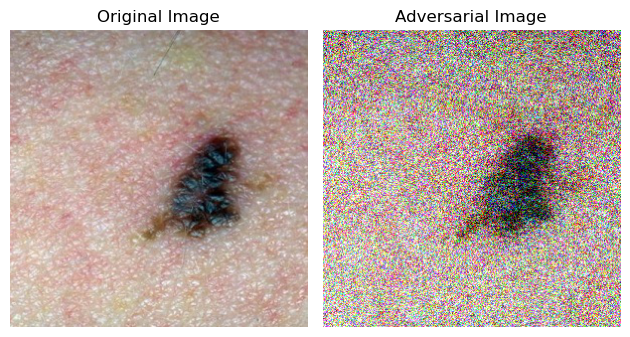

In [30]:
filepath = f"{root}data/642114296aa558155206d8465cf2da93.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.5
attacks.random_noise_attack_with_image(model, filepath, true_label, eps)

In [31]:
res = []
eps = 0.5
for i, d in test_df.iterrows():
    res.append(attacks.random_noise_attack(model, d["filepath"], d["labels"], eps))

In [32]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["RN pred"] = adv_pred
test_df["RN pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "RN")

RN Success rate: 0.29555555555555557
RN TN Success rate: 0.08333333333333333
RN FP Success rate: 0.37222222222222223


## FGSM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label: 0
Prediction: [[0.83796024]]
Prediction class: ['1']
Adversarial Prediction: [[2.2586137e-05]]
Adversarial Predicted Class: ['0']


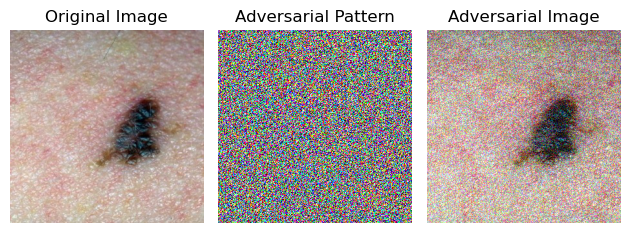

In [33]:
filepath = f"{root}data/642114296aa558155206d8465cf2da93.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.2
adv = attacks.fgsm_attack_with_image(model, filepath, true_label, eps)

In [34]:
res = []
eps = 0.2
for i, d in test_df.iterrows():
    res.append(attacks.fgsm_attack(model, d["filepath"], d["labels"], eps))

In [35]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["FGSM pred"] = adv_pred
test_df["FGSM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "FGSM")

FGSM Success rate: 0.3388888888888889
FGSM TN Success rate: 0.05333333333333334
FGSM FP Success rate: 0.41555555555555557


## Saliency Map Attack

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label: 0
Prediction: [[0.83796024]]
Prediction class: ['1']
Adversarial Prediction: [[1.]]
Adversarial Predicted Class: ['1']


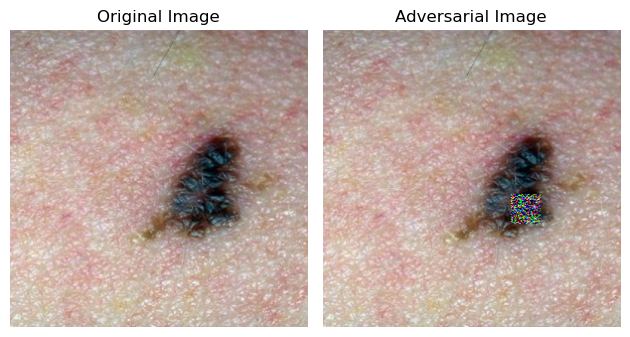

In [36]:
filepath = f"{root}data/642114296aa558155206d8465cf2da93.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 1
patch_size=30
attacks.sailency_attack_with_image(model, filepath, true_label, eps, patch_size)

In [37]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.saliency_attack(model, d["filepath"], d["labels"], eps, patch_size))

In [38]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["SM pred"] = adv_pred
test_df["SM pred class"] = adv_class

In [39]:
test_df = attacks.attack_success_rate(test_df, "SM")

SM Success rate: 0.27
SM TN Success rate: 0.40555555555555556
SM FP Success rate: 0.04888888888888889


## Data export for analysis

In [40]:
test_df.to_csv(f"{root}exp/test_df_Fitzpatrick17K_CNN.csv", index=False)